# Yelp Recommendation System

Chenchen Shentu

In [ ]:
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
%matplotlib inline

In [ ]:
#create Spark session
spark = SparkSession.builder.appName('YelpRecommendation').getOrCreate()
#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '32g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '16'), ('spark.cores.max', '16'), ('spark.driver.memory','32g')])
#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/hive/*'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.cores.max', '16'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '/opt/cloudera/parcels/CDH/lib/spark/python/lib/py4j-0.10.7-src.zip:/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/pyspark.zip'),
 ('sp

### Import Data

business & review datasets

In [ ]:
!hdfs dfs -ls /user/kfgbah/Yelp

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 5 items
-rw-r--r--   3 kfgbah kfgbah  124380583 2021-07-28 12:53 /user/kfgbah/Yelp/yelp_academic_dataset_business.json
-rw-r--r--   3 kfgbah kfgbah  398272056 2021-07-28 12:50 /user/kfgbah/Yelp/yelp_academic_dataset_checkin.json
-rw-r--r--   3 kfgbah kfgbah 6936678061 2021-07-28 12:55 /user/kfgbah/Yelp/yelp_academic_dataset_review.json
-rw-r--r--   3 kfgbah kfgbah  230307244 2021-07-28 12:52 /user/kfgbah/Yelp/yelp_academic_dataset_tip.json
-rw-r--r--   3 kfgbah kfgbah 3684505303 2021-07-28 13:05 /user/kfgbah/Yelp/yelp_academic_dataset_user.json


In [ ]:
# import datasets
df_review = spark.read.json('/user/kfgbah/Yelp/yelp_academic_dataset_review.json')
df_business = spark.read.json('/user/kfgbah/Yelp/yelp_academic_dataset_business.json')

In [ ]:
df_business.show(1)
df_business.count()

+------------+--------------------+--------------------+--------------------+-------+--------------------+-------+----------+------------+-------------------+-----------+------------+-----+-----+
|     address|          attributes|         business_id|          categories|   city|               hours|is_open|  latitude|   longitude|               name|postal_code|review_count|stars|state|
+------------+--------------------+--------------------+--------------------+-------+--------------------+-------+----------+------------+-------------------+-----------+------------+-----+-----+
|921 Pearl St|[,, 'beer_and_win...|6iYb2HFDywm3zjuRg...|Gastropubs, Food,...|Boulder|[11:0-23:0, 11:0-...|      1|40.0175444|-105.2833481|Oskar Blues Taproom|      80302|          86|  4.0|   CO|
+------------+--------------------+--------------------+--------------------+-------+--------------------+-------+----------+------------+-------------------+-----------+------------+-----+-----+
only showing top 1 r

160585

In [ ]:
df_review.printSchema()
df_review.show(1)
df_review.count()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|buF9druCkbuXLX526...|   1|2014-10-11 03:34:02|    1|lWC-xP3rd6obsecCY...|  4.0|Apparently Prides...|     3|ak0TdVmGKo4pwqdJS...|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
only sh

8635403

### Missing Values

In [ ]:
#missing values in each column
from pyspark.sql.functions import isnan, when, count, col
df_business.select([count(when(df_business[c].isNull(), c)).alias(c) for c in df_business.columns]).show()

+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|      0|     14992|          0|       115|   0|27341|      0|       0|        0|   0|          0|           0|    0|    0|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+



In [ ]:
df_review.select([count(when(df_review[c].isNull(), c)).alias(c) for c in df_review.columns]).show()

+-----------+----+----+-----+---------+-----+----+------+-------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|
+-----------+----+----+-----+---------+-----+----+------+-------+
|          0|   0|   0|    0|        0|    0|   0|     0|      0|
+-----------+----+----+-----+---------+-----+----+------+-------+



In [ ]:
df_buz = df_business.select(['business_id','categories','city','name','review_count','stars','state']) \
                    .withColumnRenamed('stars', 'stars_restaurant')

In [ ]:
df_buz = df_buz.dropna()

In [ ]:
df_buz.select([count(when(df_buz[c].isNull(), c)).alias(c) for c in df_buz.columns]).show()

+-----------+----------+----+----+------------+----------------+-----+
|business_id|categories|city|name|review_count|stars_restaurant|state|
+-----------+----------+----+----+------------+----------------+-----+
|          0|         0|   0|   0|           0|               0|    0|
+-----------+----------+----+----+------------+----------------+-----+



In [ ]:
df_buz.count()

160470

### Queries

In [ ]:
# Top 5 cities with most stores
df_buz.groupby('city').count().orderBy(['count'], ascending=[0]).show(5)

+---------+-----+
|     city|count|
+---------+-----+
|   Austin|22399|
| Portland|18187|
|Vancouver|13325|
|  Atlanta|12607|
|  Orlando|10635|
+---------+-----+
only showing top 5 rows



In [ ]:
# Top 5 states with most stores
df_buz.groupby('state').count().orderBy(['count'], ascending=[0]).show(5)

+-----+-----+
|state|count|
+-----+-----+
|   MA|35973|
|   OR|25151|
|   TX|24464|
|   FL|21900|
|   GA|18079|
+-----+-----+
only showing top 5 rows



In [ ]:
# Top 5 categories with most stores
df_buz.groupby('categories').count().orderBy(['count'], ascending=[0]).show(5)

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|Beauty & Spas, Ha...|  757|
|  Restaurants, Pizza|  748|
|Hair Salons, Beau...|  742|
|  Pizza, Restaurants|  740|
|Beauty & Spas, Na...|  734|
+--------------------+-----+
only showing top 5 rows



### Data Preprocessing

In [1]:
# only use categories including restaurants
df_buz1 = df_buz.filter(df_buz.categories.contains('Restaurants'))
df_buz1.count()

NameError: ignored

In [ ]:
# Filter out restaurants/users that have very few (<10) reviews to restrict sparsity
buz_with_10_ratings_or_more = df_review.groupby('business_id').agg(F.count(df_review.stars).alias('business_count')).filter(col('business_count')>=10)
user_with_10_reviews_or_more = df_review.groupby('user_id').agg(F.count(df_review.stars).alias('user_count')).filter(col('user_count')>=10)

In [ ]:
# join dataframes
df_review = df_review.join(df_buz1, on='business_id', how='inner')
df_review = df_review.join(buz_with_10_ratings_or_more, on='business_id', how='inner')
df_review = df_review.join(user_with_10_reviews_or_more, on='user_id', how='inner')

In [ ]:
df_review.show(3)

In [ ]:
df_review.count()

### Data Visualization

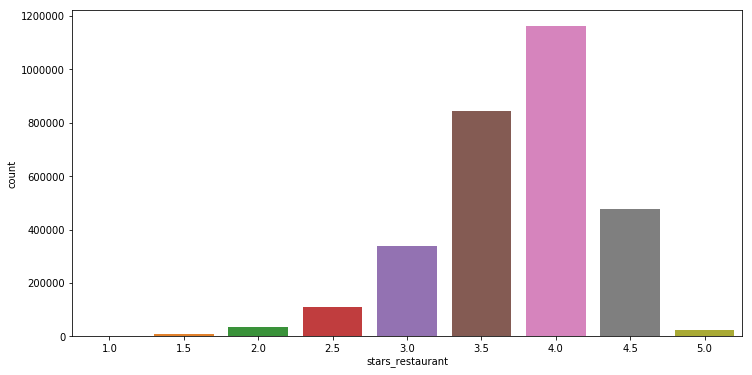

In [ ]:
# Restaurant stars distribution
df_pd1 = df_review.groupby(df_review.stars_restaurant).count().orderBy(['stars_restaurant'], ascending=[0]).toPandas()
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='stars_restaurant', y='count', data=df_pd1, ax=ax)

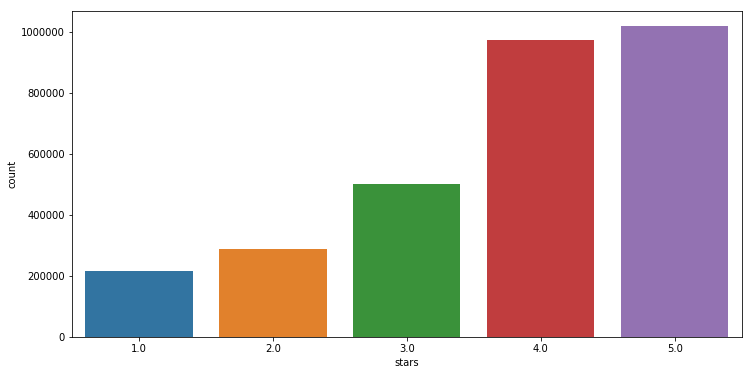

In [ ]:
# User review stars distribution
df_pd2 = df_review.groupby(df_review.stars).count().orderBy(['stars'], ascending=[0]).toPandas()
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='stars', y='count', data=df_pd2, ax=ax)

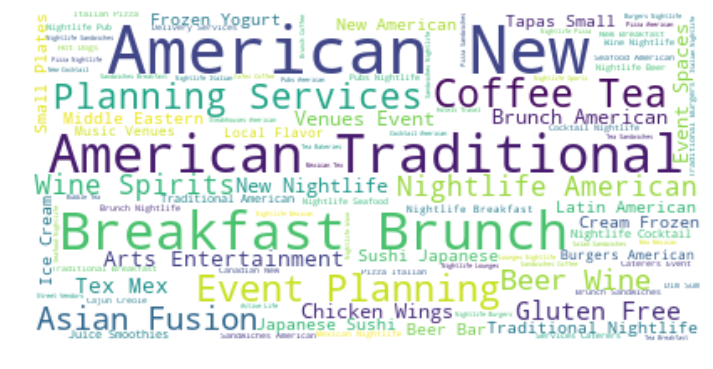

In [ ]:
# Popular restaurant wordcloud
restaurant_categories = df_review.select('categories').collect()
restaurant_categories_list = [restaurant_categories[i][0] for i in range(len(restaurant_categories))]
text = " ".join(review for review in restaurant_categories_list)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = text.replace('Restaurants', "")
text = text.replace('Bars', "")
text = text.replace('Food', "")
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Recommendation Model

In [ ]:
# Convert string to index
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_review).transform(df_review)

In [ ]:
transformed.show(1)

+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+----+--------------+------------+----------------+-----+--------------+----------+-----------------+-------------+
|             user_id|         business_id|cool|               date|funny|           review_id|stars|                text|useful|          categories|city|          name|review_count|stars_restaurant|state|business_count|user_count|business_id_index|user_id_index|
+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+----+--------------+------------+----------------+-----+--------------+----------+-----------------+-------------+
|-0KAIqdO-DhrIXcY9...|_Fs1js9sOEFDJ2Txg...|   0|2018-05-16 23:26:26|    0|3H8URHtE7FBDVKT3d...|  1.0|The guy that answ...|     0|Food, Restaurants...|Kyle|Sonic Drive-In|          41|             2.0|   TX

In [ ]:
# Split dataset in train and test
(training, test) = transformed.randomSplit([0.8, 0.2])

In [ ]:
# Create ALS model
als = ALS(maxIter=18,
          regParam=0.09,
          rank=25,
          userCol="user_id_index",
          itemCol="business_id_index",
          ratingCol="stars",
          coldStartStrategy="drop",
          nonnegative=True)

In [ ]:
model = als.fit(training)

In [ ]:
# Evaluate RMSE
evaluator = RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
rmse

1.185578110486221

In [ ]:
# Predictions
predictions = predictions.na.drop()
predictions.show(3)

+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+---------+-----------+------------+----------------+-----+--------------+----------+-----------------+-------------+----------+
|             user_id|         business_id|cool|               date|funny|           review_id|stars|                text|useful|          categories|     city|       name|review_count|stars_restaurant|state|business_count|user_count|business_id_index|user_id_index|prediction|
+--------------------+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+---------+-----------+------------+----------------+-----+--------------+----------+-----------------+-------------+----------+
|LGN94e8YgLlZCJ0Ta...|C7FKNwSUlbUinT9cR...|   0|2014-10-15 22:19:38|    0|IYzih-wFQx-hL9-C1...|  5.0|Do you like a cre...|     0|Lounges, Bars, Co...|Cambridge|Cuchi 

### Recommendation for a User 

Randomly choose a user with user_id_index = 66

In [ ]:
test1 = model.recommendForAllUsers(1000).filter(col('user_id_index')==66).select('recommendations').collect()

topRestaurants = []
for item in test1[0][0]:        
    topRestaurants.append(item.business_id_index)
    
schema = StructType([StructField("business_id_index",IntegerType(),True)])
restaurants = spark.createDataFrame(topRestaurants,IntegerType()).toDF("business_id_index")

#### User Review History

In [ ]:
user_history = transformed.select(['business_id', 'user_id', 'stars', 'categories', 'city'])\
                          .filter(col('user_id_index')==66)

In [ ]:
review_count = user_history.groupby('business_id').count().orderBy(['count'], ascending=[0])

In [ ]:
user_history.join(review_count, on='business_id', how='inner').orderBy(['count'], ascending=[0]).show(10)

+--------------------+--------------------+-----+--------------------+----------+-----+
|         business_id|             user_id|stars|          categories|      city|count|
+--------------------+--------------------+-----+--------------------+----------+-----+
|pvlM--HZY1a8SqMXi...|ir689oBNmrJXOspb4...|  4.0|Restaurants, Caju...| Cambridge|    3|
|pvlM--HZY1a8SqMXi...|ir689oBNmrJXOspb4...|  2.0|Restaurants, Caju...| Cambridge|    3|
|pvlM--HZY1a8SqMXi...|ir689oBNmrJXOspb4...|  4.0|Restaurants, Caju...| Cambridge|    3|
|BTOz5Mmq-nJC92ck4...|ir689oBNmrJXOspb4...|  5.0|Sandwiches, Burge...| Cambridge|    2|
|AA3s5dGi0fQCwBZnh...|ir689oBNmrJXOspb4...|  4.0|Gluten-Free, Rest...|    Boston|    2|
|qhz_ypl5rVzP-sJ-7...|ir689oBNmrJXOspb4...|  4.0|Pubs, Restaurants...| Cambridge|    2|
|AA3s5dGi0fQCwBZnh...|ir689oBNmrJXOspb4...|  4.0|Gluten-Free, Rest...|    Boston|    2|
|Q-_5cf30RqSxqD-_r...|ir689oBNmrJXOspb4...|  5.0|Seafood, Indian, ...|Somerville|    2|
|DjeCpbZ2eyc4YSheL...|ir689oBNmr

#### Restaurants recommended to user (user_id = ir689oBNmrJXOspb4yq_Jg)

In [ ]:
rec_restaurants = restaurants.join(transformed, on = 'business_id_index', how = 'inner')\
                             .select(['business_id', 'stars', 'categories', 'name', 'city'])\
                             .drop_duplicates(subset=['name'])\
                             .orderBy(['stars'], ascending=[0])

In [ ]:
rec_restaurants.show(10)

+--------------------+-----+--------------------+--------------------+----------------+
|         business_id|stars|          categories|                name|            city|
+--------------------+-----+--------------------+--------------------+----------------+
|cdiPkxkaCM7OX8KTr...|  5.0|Food, Food Trucks...|    Tacoriendo Movil|        Columbus|
|HvS2_mcp34JkMlw1Q...|  5.0|Mediterranean, Re...|Sufra Mediterrane...|          Boston|
|rGs0vEyN3puNd9RiI...|  5.0|Diners, Bakeries,...|          Roadworthy|          Dedham|
|qSt3ULwOPhoDk43Vi...|  5.0|Restaurants, Fast...|    Taqueria Jalisco|        Columbus|
|j6MeULMQrKtuOQ4HA...|  5.0|Food, Hawaiian, R...|          Bigbelly's|     Winter Park|
|8YFDiCVUjFdiYVA0m...|  5.0|Donuts, American ...|  Kim's Donut & Deli|      Titusville|
|wTVzfhLOYUyd6wY9L...|  5.0|Soup, Thai, Resta...|Khob Khun Thai Cu...|       Coquitlam|
|MgIylzMhBjJ6XyGyz...|  5.0|American (Traditi...|       Van's Banh Mi|          Austin|
|vc-ZGUcrV9KNFX1qd...|  5.0|Brea

#### Restaurants recommended to this user in Boston

In [ ]:
rec_restaurants.filter(col('city')=='Boston').show(10)

+--------------------+-----+--------------------+--------------------+------+
|         business_id|stars|          categories|                name|  city|
+--------------------+-----+--------------------+--------------------+------+
|SsESo3rbVu1K6ORJn...|  5.0|Food, Restaurants...|   Quinzani's Bakery|Boston|
|smkW4HHpwAWzCb5ki...|  5.0|Restaurants, Gues...|             No. 284|Boston|
|fL7nYIkjvs6Aa9jSu...|  5.0|Pet Stores, Resta...|     Polkadog Bakery|Boston|
|Y7X3FeUfwE9pEWZxN...|  5.0|Food, Sandwiches,...| Monica’s Pasta Shop|Boston|
|eJAfLazNvKQbReTgZ...|  5.0|Italian, Food, Fo...|Stoked Wood Fired...|Boston|
|8RUV3Lqi_sZ1ytK83...|  5.0|Halal, Restaurant...|Garbanzo Mediterr...|Boston|
|HYX36WXeTtqnDC4bc...|  5.0|American (New), H...|Scup's In The Har...|Boston|
|HvS2_mcp34JkMlw1Q...|  5.0|Mediterranean, Re...|Sufra Mediterrane...|Boston|
|Lwys_i_3iIPlUCHJr...|  5.0|Cafeteria, Americ...|Dana Farber Cance...|Boston|
|OP0xCQM6ih4VEhl2t...|  5.0|Italian, Restaurants|        Rino's 

#### Restaurants recommended to this user including Pizza

In [ ]:
rec_restaurants.filter((col('categories').contains('Pizza')) & (col('city')=='Boston')).show(10)

+--------------------+-----+--------------------+--------------------+------+
|         business_id|stars|          categories|                name|  city|
+--------------------+-----+--------------------+--------------------+------+
|eJAfLazNvKQbReTgZ...|  5.0|Italian, Food, Fo...|Stoked Wood Fired...|Boston|
|yx_tOt-p-pxWNWAc2...|  5.0|Pasta Shops, Rest...|           Casalinga|Boston|
|7_q1IsPoR25clSoig...|  5.0|Italian, Mediterr...|            Pomodoro|Boston|
+--------------------+-----+--------------------+--------------------+------+



### Recommendation for a Restaurant

Randomly choose a restaurant with business_id_index = 66

In [ ]:
test2 = model.recommendForAllItems(20).filter(col('business_id_index')==66).select('recommendations').collect()
topUsers = []

for item in test2[0][0]:        
    topUsers.append(item.user_id_index)
    
schema = StructType([StructField("user_id_index",IntegerType(),True)])
users = spark.createDataFrame(topUsers,IntegerType()).toDF("user_id_index")

#### Restaurant Information

In [ ]:
restaurant_info = transformed.select(['business_id', 'stars_restaurant', 'categories', 'city'])\
                             .filter(col('business_id_index')==66)

In [ ]:
restaurant_info.show(1)

+--------------------+----------------+--------------------+-------+
|         business_id|stars_restaurant|          categories|   city|
+--------------------+----------------+--------------------+-------+
|tbX4pEVxWuPgxG01l...|             4.5|Latin American, B...|Orlando|
+--------------------+----------------+--------------------+-------+
only showing top 1 row



#### Users recommended to restaurant (business_id = tbX4pEVxWuPgxG01l-pAOQ)

In [ ]:
rec_users = users.join(transformed, on = 'user_id_index', how = 'inner')\
                 .select(['user_id','user_id_index'])\
                 .drop_duplicates(subset=['user_id'])

In [ ]:
rec_users.show(truncate=False)

+----------------------+-------------+
|user_id               |user_id_index|
+----------------------+-------------+
|zyjYjO-0NSp5JHhYJ-Br0A|30948        |
|921g0ra2_kwuW1Yo8mGxeQ|664          |
|tZvJmvR1jMhiJ0jLOTy_JQ|56970        |
|FHTmjP0SHhDlvFsmtAQ2mg|142844       |
|pQyTcz8ZTIuebQlcNg6QvA|90469        |
|SKYgMVU4CebGWkxFEKlhxQ|148997       |
|FTuMEHMYgCqJKOuAgxDmzg|117526       |
|G9t0VmHR7Zcg3KS0lolW8Q|101515       |
|3YgkHy9sB2N0U_mtHNmuPA|45884        |
|8j2BAwJolI2ID650ome3ng|81093        |
|6SguBm5-r2T67P9akh7bxw|94118        |
|bnyNr8V0XCLcPhp120dZpQ|73813        |
|Cg1IAO9xgdhTFswscN2bjw|117205       |
|3f6gq457QNGb5YYh7-oDaA|9936         |
|bNt-KgxrK5-JWXB00dPaEg|15886        |
|-xxC_3iAMpIxs6zQLzLS-g|71651        |
|ugJOthSIzDmYQg5KEGms1g|102349       |
|b1yuPTG88u7Yb1E1AdgYuA|77468        |
|UcxLOvMf7Ign0NomosLs3w|50732        |
|QC-qg0x2svw-MCmycuz3Gw|31152        |
+----------------------+-------------+



### Recommendation to a New User

Random User Input: City (Boston), Category (Pizza), Special Requests (Take Out)

In [ ]:
df_buz3 = df_business.select(['attributes','business_id','categories','city',
                             'is_open','name','review_count','stars','state'])

In [ ]:
df_buz3 = df_buz3.filter(df_buz3.categories.contains('Restaurants'))
df_buz3.count()

50763

In [ ]:
df_buz3.select([count(when(df_buz3[c].isNull(), c)).alias(c) for c in df_buz3.columns]).show()

+----------+-----------+----------+----+-------+----+------------+-----+-----+
|attributes|business_id|categories|city|is_open|name|review_count|stars|state|
+----------+-----------+----------+----+-------+----+------------+-----+-----+
|       449|          0|         0|   0|      0|   0|           0|    0|    0|
+----------+-----------+----------+----+-------+----+------------+-----+-----+



In [ ]:
df_buz3.filter((col('city')=='Boston')&(col('categories').contains('Pizza'))
              &(df_buz3.attributes.RestaurantsTakeOut=='True')&(col('is_open')==1)) \
       .orderBy(['stars'], ascending=[0]) \
       .select(['business_id','name','categories','stars','review_count']) \
        .show()

+--------------------+--------------------+--------------------+-----+------------+
|         business_id|                name|          categories|stars|review_count|
+--------------------+--------------------+--------------------+-----+------------+
|IJ2MnBlIvib0aU2hb...|   The Brewer's Fork|Beer Gardens, Nig...|  4.5|         383|
|RigU2n4W4NCl3bdPg...|Milano's Delicate...|Grocery, Pizza, D...|  4.5|          77|
|pksM6e_ajgLkX-mSC...|Rinas Pizzeria & ...|Salad, Italian, P...|  4.5|         188|
|7R68Kg6adnzicSp5m...|       Toasted Flats|Pizza, Sandwiches...|  4.5|          74|
|5fAhoG03Qy99lI0v7...|              Locale|Pizza, Beer, Wine...|  4.5|         381|
|7OeeR33JLLrHEj9qD...|               Scopa|Salad, Italian, P...|  4.5|         250|
|mdqoWOmXCP5dqQ0IW...|     Roy's Cold Cuts|Food, Delis, Rest...|  4.5|          96|
|XoNu3QErSOOztKgdQ...|     Rhythm 'n Wraps|Event Planning & ...|  4.5|          52|
|IzRf6C66CeF57fgvK...|              Cini’s|Restaurants, Pizz...|  4.5|      